# Code

In [1]:
import json
import jsonlines
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from pprint import pprint
from tqdm import tqdm

In [2]:
def load_dir(dataset: list, path: str, label: bool, sort=True):
    dataset.sort(key=lambda e: e["id"])
    if dataset:
        index = dataset[-1]["id"]+1
    else:
        index = 0
    fnames = [(path+"/Red/"+i[:2]+"_Red.txt", path+"/Green/"+i[:2]+"_Green.txt",path+"/Blue/"+i[:2]+"_Blue.txt") for i in [i for i in os.walk(path)][1][2]]
    for fname in fnames:
        person = {"id": index}
        person["label"] = label
        with open(fname[0],"r") as rfile, open(fname[1],"r") as gfile, open(fname[2],"r") as bfile:
            person["r"] = [float(i) for i in rfile.readlines()[1:]]
            person["g"] = [float(i) for i in gfile.readlines()[1:]]
            person["b"] = [float(i) for i in bfile.readlines()[1:]]
        
        if sort:
            person["r"].sort()
            person["g"].sort()            
            person["b"].sort()
        
        index+=1
        dataset.append(person)
        
def load_dataset(dataset: list, path: str, pathpos: str, pathneg: str, sort=True):
    load_dir(dataset, path+"/"+pathpos, True, sort=sort)
    load_dir(dataset, path+"/"+pathneg, False, sort=sort)    
        
        
# def get_filter(dataset: list, filter: str):
#     if filter!="r" and filter!="g" and filter!="b":
#         raise ValueError('Wrong filter: must be "r", "g", "b"')
#     new_dataset = []
#     for person in dataset:
#         new_dataset.append({"id": person["id"], "label": person["label"], "data": person[filter]})
    
#     return new_dataset

def show_plot_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for i in np.arange(0,len(dataset), 1):
        color="green"
        if dataset[i]["label"]:
            color="red"
        for j in dataset[i][filter]:
            plt.plot(i,j, "o", markersize=0.5, color=color)
    plt.show()

    
def binarize_person(person: dict, precision=1e-6, up=1.8, down=0.2, radius=0, flatten=True):
    person_data = np.zeros((3, int((up-down)//precision)+1), np.float32)
    
    dots  = (
        ((np.array(person["r"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["g"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["b"]).clip(down, up)-down)//precision).astype(np.uint32))
    
    for color_index in range(3):
        for dot in dots[color_index]:
            person_data[color_index][max(0, dot-radius) : min(dot+radius+1, person_data.shape[1])].fill(1)
    
    if flatten:
        return {"id": person["id"], "label": person["label"], "data": person_data.flatten()}
    else:
        return {"id": person["id"], "label": person["label"], "data": person_data}

def show_plot_avg_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for person in dataset:
        
        if person["label"]:
            color="red"
            x = 0
        else:
            color="green"
            x = 1
             
        for y in person[filter]:
            plt.plot(x,y, "o", markersize=0.5, color=color)
    plt.show()
    


# Loading dataset

In [3]:
dataset = []
load_dataset(dataset, "data_orig/Data", "BC", "Control")

# Number of cells

In [5]:
for c in 'r', "g", "b":
    l = [len(i[c]) for i in dataset]
    print(f"max min {c}: {max(l)}, {min(l)}")
len(dataset)

max min r: 81, 24
max min g: 81, 24
max min b: 81, 24


97

# Visulaisation of cells fractal dimensions for each person (97)

## Red filter

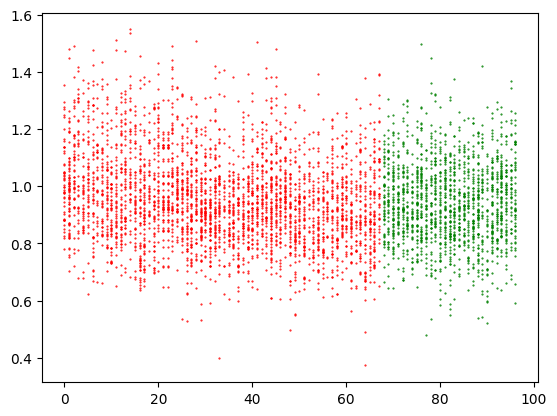

In [4]:
show_plot_by_filter(dataset, "r")

## Green

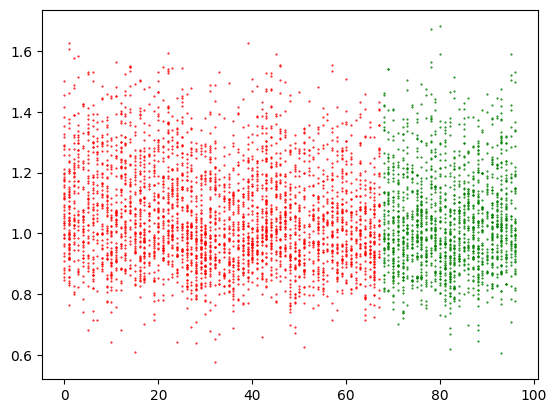

In [165]:
show_plot_by_filter(dataset, "g")

## Blue

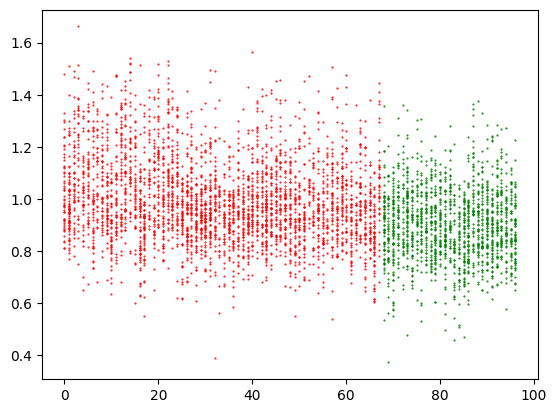

In [6]:
show_plot_by_filter(dataset, "b")

# Combined cancer-pos and -neg dots

## Red:

In [ ]:
show_plot_avg_by_filter(dataset, "r")

## Green:

In [ ]:
show_plot_avg_by_filter(dataset, "g")

## Blue:

In [ ]:
show_plot_avg_by_filter(dataset, "b")

# Generation of binarized dataset

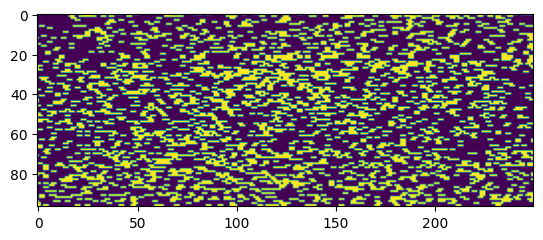

In [87]:
dataset_bin = [binarize_person(p, precision=1e-3, radius=1, up=2, down=0) for p in dataset]
raw_data = np.array([i["data"] for i in dataset_bin], dtype=np.float32)
plt.imshow(raw_data[:,:int(raw_data.shape[1]//3)][:,800:1050])

In [8]:
(dataset_bin[0])

{'id': 0,
 'label': True,
 'data': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}

# One-leave-out validation for 97 classes (Hopfield)

In [9]:
import sys
sys.path.append("c:/users/user/Desktop/hopfield-izhikevich/hopfield")

In [10]:
from hopfield import Hopfield

In [11]:
q = 0
pos = 0
time = 5



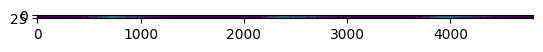

In [166]:
for i in tqdm(range(len(dataset_bin))):
    _mask = np.ones(len(dataset_bin), dtype=bool)
    _mask[i] = False

    _X = dataset_bin[i]["data"]*2-1
    _images = raw_data[_mask]*2-1
    
    model = Hopfield(q=q, np_type=np.float32)
    model.train(images=_images)
    # print("trained")
    output = model.run(X=_X, time=time)
    
    output["output"] = (output["output"] + 1)*2
    for j in range(len(dataset_bin)-1):
        if (raw_data[_mask][j]==output["output"]).all():
            if i>j:
                if dataset_bin[i]["label"]==dataset_bin[j]["label"]:
                    pos+=1
                    break
            elif dataset_bin[i]["label"]==dataset_bin[j+1]["label"]:
                pos+=1
                break
            
        
print(pos)

 28%|██████████████████████▊                                                           | 27/97 [00:12<00:33,  2.11it/s]


KeyboardInterrupt: 

In [ ]:
(raw_data.shape[1]*raw_data.shape[1])*raw_data.itemsize/1024/1024

88.00052261352539

In [162]:
i = random.randint(0,96)
j = random.randint(0,96)
sum(raw_data[i]==raw_data[j])

3938

In [51]:
binary_output = (np.array([i["output"] for i in out], dtype=np.float32)+1)/2.0

In [53]:
pos = 0
for i in range(len(binary_output)):
    flag=False
    for j in range(len(dataset_bin)):
        if (binary_output[i]==dataset_bin[j]).all():
            if :
                pos+=1
            
            
            

(97, 4803)